# To analyze and classify the harmonized dataset
* note that some classifiers may require using a computer cluster due to memory requirements
* These package versions were used for the manuscript: scikit-learn v1.3.2, catboost v1.2.3, xgboost v2.0.3, lightgbm v4.3.0, joblib v1.3.2, optuna v3.5.0, numpy v1.23.4, pandas v2.0.0

In [105]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
#import chart_studio.plotly as py
#import plotly.express as px
#import plotly.graph_objects as go
#from matplotlib import colors
import os
import json
import sys
from numpy import ma
import seaborn as sns
import logging
#pd.set_option('display.max_columns',200)
#import plotnine as p9
#from plotnine import *
#from plotnine.data import *

from scipy import stats
from scipy.stats import zscore
#from natsort import natsorted
from glob import glob
import glob
from statistics import mean
#import shutil
import random
import copy
#from scipy.stats import shapiro, skew

#import lime
#import lime.lime_tabular

#logger = logging.getLogger(__name__)
#logger.setLevel(logging.INFO)
#logging.basicConfig()

import joblib

#import sklearn.datasets

#from sklearn.preprocessing import FunctionTransformer
#from sklearn.metrics import plot_roc_curve
#from sklearn.inspection import plot_partial_dependence, permutation_importance
#from sklearn.metrics import RocCurveDisplay, plot_confusion_matrix, plot_precision_recall_curve, roc_curve

#import PipelineProfiler
from joblib import dump, load
import scikitplot as skplt
#from sklearn.metrics import classification_report
import optuna
import scipy.stats as stats
import math
import random
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
#from scipy.stats import shapiro, skew
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.base import BaseEstimator, TransformerMixin
#from sklearn.calibration import CalibratedClassifierCV
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFECV, RFE, SelectKBest, chi2
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier, ElasticNetCV, LassoLarsCV, ElasticNet, LogisticRegression
import sklearn.metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, matthews_corrcoef, mean_squared_error, r2_score, mean_absolute_error, cohen_kappa_score, make_scorer
from sklearn.metrics import classification_report, roc_auc_score, auc, RocCurveDisplay, roc_curve
import sklearn.model_selection
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, StratifiedKFold, KFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer, MinMaxScaler, PowerTransformer, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.svm import SVC, LinearSVC

# Hide warnings 
import warnings
warnings.filterwarnings("ignore")
#plotly_template = 'simple_white'

In [106]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls')

In [107]:
# make some lists to fill later

dfTrainModelEvalAllSeeds = pd.DataFrame()
seedListStats = []
trainFracListStats = []
finalClassifierList = []
tunedClassifierListForValidation = []
finalImportancesMeanList = []
finalFeaturesList = []

y_testList = []
y_predList = []
y_probList = []
seedList = []
seedListStats = []
trainFracListStats = []

In [108]:
# key parameters

seed = 7 # use seeds 1-7 for each classification to randomize 7 times
np.random.seed(7) # match the seed value
target = 'dfHarmonizedCancer'
quantType = 'areaHarmonized'
trainFrac = .75
nJobs = 6
nSamplesVal = 60

In [109]:
# This function takes a dataframe and a target variable to create an X (predictors) dataframe and a y Series

def X_y_split(df, target):
    
    categorical_features = []
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        if df[col].dtype == object:
            categorical_features.append(col)
        
        else:
            if df[col].nunique() <= 2:
                binary_features.append(col)
            else:
                continuous_features.append(col)
                
    if categorical_features: # if this list isn't empty
        if target in categorical_features:
            categorical_features.remove(target)
        df.drop(categorical_features, axis = 1, inplace = True)

    X, y = df.drop([target], axis = 1), df[target]
    
    return X, y

In [110]:
# This function parses columns by type.

def columns_catNumOrBin(df):

    categorical_features = []
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        if df[col].dtype == object:
            categorical_features.append(col)
        else:
            if df[col].nunique() <= 2:
                binary_features.append(col)
            else:
                continuous_features.append(col)
    
    return categorical_features,continuous_features, binary_features

In [111]:
# impute 0s

def imputeWideDFMinOr0(df):
    
    for col in df.columns:

        if df[col].dtype == object:
            continue
        
        else:
        
            if quantType == 'areaHarmonized': # i think min makes sense
                df[col].fillna(value = df[col].min(), inplace = True)
        
    return df

In [112]:
# load harmonized output from the Harmonizernotebook

dfHarmonized = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure2_Data_CancerVsNormal/dfHarmonized.xlsx', index_col=0)
dfHarmonized.rename({'cancer':'dfHarmonizedCancer'}, axis='columns', inplace = True)
dfHarmonized.head()

,sensitivity,dataset,patient,group,sample,timing,dataType,race,gender,dfHarmonizedCancer,...,species,sampleType,category,Reviewed,Protein names,geneNamePrimary,nSamples,areaScaled,areaHarmonized,areaHarmonizedAntilog
0,S,sarcoma,BJW,S.Pre,BJW.S.Pre,Pre,Intensity_Raw,WHITE,M,c,...,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7,106,-0.158046,0.999174,1.998855
1,R,sarcoma,BPA,R.Pre,BPA.R.Pre,Pre,Intensity_Raw,WHITE,M,c,...,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7,106,-0.824573,0.292549,1.224802
2,S,sarcoma,BPE,S.Pre,BPE.S.Pre,Pre,Intensity_Raw,WHITE,M,c,...,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7,106,-0.763513,0.357283,1.281011
3,S,sarcoma,BPV,S.Pre,BPV.S.Pre,Pre,Intensity_Raw,WHITE,F,c,...,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7,106,-1.288444,-0.199228,0.871016
4,S,sarcoma,BTK,S.Pre,BTK.S.Pre,Pre,Intensity_Raw,WHITE,M,c,...,NaN,NaN,NaN,reviewed,Probable non-functional immunoglobulin kappa v...,IGKV3-7,106,-1.285697,-0.196317,0.872776


In [113]:
def tidyDFHarmonized (df): # 'Intensity_Raw', 'NormalizedIntensity_Log2'

    global quantType
    
    df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants    
    df.drop(columns = ['areaHarmonizedAntilog', 'areaScaled', 'area'], inplace = True) # not using these quant columns

    totalCols = df.columns
    numCols = df._get_numeric_data().columns
    catCols = list(set(totalCols)-set(numCols))
    catCols.remove('geneNamePrimary')
    catCols.remove('sample')
    catCols.remove(target)
    
    #remove rows without areas & duplicates
    df.dropna(subset=[quantType], inplace=True)
    df.drop_duplicates(inplace = True)

    return df

In [114]:
# tidy the dataframe

dfHarmonized = tidyDFHarmonized(dfHarmonized)

### Filter dfHarmonized

In [115]:
def removeCrapome(df):
    crapome =['KRT1', 'KRT2', 'KRT3', 'KRT4', 'KRT5', 'KRT6', 'KRT7', 'KRT8', 'KRT9', 'KRT10', 'KRT11', 'KRT12', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17', 'KRT18', 'KRT19', 'KRT20', 'KRT21', 'KRT22', 'KRT23', 'KRT24']
    df.query('geneNamePrimary not in @crapome', inplace = True)

    return df

In [116]:
dfFiltered = removeCrapome(dfHarmonized)

In [117]:
# count protein IDs

def filterNDetectionsPerProtAcc(df, nSamplesVal_):

    global nSamplesVal
    nSamplesVal = nSamplesVal_
    print(nSamplesVal)
    
    df = df.query('nSamples >= @nSamplesVal') # variable set above
    
    return df

In [118]:
dfFiltered = filterNDetectionsPerProtAcc(dfFiltered, nSamplesVal)

60


### impute NANs

In [119]:
def imputeDfMinOr0 (df, colToImpute):
    
    df[colToImpute].fillna(value = df[colToImpute].min(), inplace = True)
        
    return df

In [120]:
dfFiltered = imputeDfMinOr0(dfFiltered, 'areaHarmonized')

### pivot to wide data

In [121]:
# define columns by feature type
categorical_features,continuous_features, binary_features = columns_catNumOrBin(dfFiltered)

# pivot df by geneNamePrimary
indexListTemp = categorical_features.copy()
indexListTemp.remove('geneNamePrimary')
indexListTemp.remove('protAcc')
indexListTemp.remove('Reviewed')
indexListTemp.remove('Protein names')

dfML = pd.pivot_table(
    dfFiltered,
    values = 'areaHarmonized',
    columns = 'geneNamePrimary',
    index = ['sample', target]
).reset_index()

dfML

geneNamePrimary,sample,dfHarmonizedCancer,A1BG,A2M,ACTA1,ACTB,ACTBL2,ACTG1,ACTG2,ACTN1,...,VIM,VTN,VWF,WDR1,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ
0,BIE.S.Pre,c,0.830252,NaN,1.529702,NaN,0.238035,NaN,NaN,0.605869,...,-0.662153,1.651220,1.552332,0.394781,0.568536,0.793171,0.088769,0.297304,0.425608,0.877359
1,BIH.S.Pre,c,0.332276,NaN,1.309366,NaN,0.478284,NaN,NaN,0.456010,...,0.410026,1.576208,1.427785,-0.010363,-0.163921,0.264368,-0.276322,0.307422,0.205803,0.476802
2,BIP.S.Pre,c,0.357704,NaN,1.208670,NaN,-0.486699,NaN,NaN,0.312867,...,-0.271596,1.465018,1.357034,0.002520,-0.153920,0.293756,-0.187815,0.363499,0.159687,0.525286
3,BJE.R.Pre,c,0.482507,NaN,1.400820,NaN,0.432288,NaN,NaN,0.640151,...,0.263245,1.466153,1.407550,0.464374,0.455905,0.528796,0.104778,0.395489,0.370452,0.871807
4,BJK.R.Pre,c,0.652147,NaN,1.550001,NaN,0.495373,NaN,NaN,0.642554,...,-0.089003,1.599650,1.635177,0.675694,0.686577,0.867544,-0.069715,0.407808,0.310482,0.880123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,MS194879LUM_goncalo_lyden_137_Plasma_a,c,0.695520,2.162397,0.620386,0.152694,0.029239,0.256713,0.125511,NaN,...,NaN,1.286680,1.280491,NaN,-0.504451,-0.612937,-0.544749,-0.490847,-0.575711,-0.186766
173,MS194879LUM_goncalo_lyden_141_Plasma_a,c,0.561369,2.294855,1.989700,1.506687,1.542420,1.693424,1.588997,0.891286,...,NaN,1.260654,1.245262,0.099659,0.677961,0.876450,0.702891,0.786348,0.816816,1.141525
174,MS194879LUM_goncalo_lyden_142_Plasma_a,c,0.592910,2.337891,1.489827,1.014633,0.979343,1.144509,1.081129,-0.105925,...,NaN,1.214992,0.924127,-0.631446,0.277585,0.419303,0.280890,0.324307,0.330923,0.792864
175,NS172995QEp_Ayuko_Lyden_CTRL63_plasma,n,0.531825,2.062484,0.391271,-0.456651,-0.667611,-0.169866,-0.128379,NaN,...,NaN,0.803730,0.231407,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## remove categorical columns

In [122]:
categorical_features,continuous_features, binary_features = columns_catNumOrBin(dfML)

In [123]:
def dfRemoveAllCatColsButTarget(df):
    
    categorical_features = []
    continuous_features = []
    binary_features = []
    
    for col in df.columns:
        if df[col].dtype == object:
            categorical_features.append(col)
        
        else:
            if df[col].nunique() <= 2:
                binary_features.append(col)
            else:
                continuous_features.append(col)
    
    categorical_features.remove(target)
        
    df.drop(categorical_features, axis = 1, inplace = True)
    
    return df

In [124]:
dfML = dfRemoveAllCatColsButTarget(dfML)

### Split dfML into training, validation, and testing datasets prior to any transformation or feature selection.

In [125]:
df = dfML.copy()

# random splitting into each set
dfTrain = df.groupby(target, group_keys=False).sample(frac=trainFrac, random_state=seed)
dfTest = df[~df.index.isin(dfTrain.index)]

# validation fraction, samples taken from dfTrain.
valFrac = .20

dfValidation = dfTrain.groupby(target, group_keys=False).sample(frac=valFrac, random_state=seed)
dfTrain= dfTrain[~dfTrain.index.isin(dfValidation.index)]

In [131]:
# save

df = dfML
df = df.reset_index(drop = True)
df.to_excel('dfML-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '.xlsx')

df = dfTest
df = df.reset_index(drop = True)
df.to_excel('_dfTest_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')

df = dfValidation
df = df.reset_index(drop = True)
df.to_excel('_dfValidation_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')

df = dfTrain
df = df.reset_index(drop = True)
df.to_excel('_dfTrain_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')

In [24]:
# Split into X and y

X, y = X_y_split(dfTrain, target)

In [25]:
imputeWideDFMinOr0(X)

geneNamePrimary,A1BG,A2M,ACTA1,ACTB,ACTBL2,ACTG1,ACTG2,ACTN1,ACTN4,ADAM10,...,VIM,VTN,VWF,WDR1,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ
110,0.427119,2.065347,0.530682,-0.129343,-0.423379,-0.024570,0.026106,-1.836067,-1.606185,-1.860046,...,-1.030240,1.526734,1.481474,-2.104248,-0.274566,-0.196867,-0.607559,-0.250478,-0.308128,-0.316296
146,0.376259,2.141387,1.295984,0.638655,0.628846,0.946476,0.874163,-1.836067,-1.606185,-1.860046,...,0.764930,0.673287,1.111831,-0.828170,-0.138130,0.010782,-0.160418,-0.101406,-0.190496,0.486893
126,0.562377,2.207797,-0.140634,-0.330657,-0.571826,-0.477617,-0.717801,-1.836067,-1.606185,-1.860046,...,-1.030240,1.117175,1.010081,-2.104248,-1.796210,-1.862757,-2.926084,-2.320411,-2.936509,-1.604599
121,0.772372,1.888034,-0.285125,-1.099648,-0.873302,-0.910295,-0.877917,-1.836067,-1.606185,-1.860046,...,-1.030240,1.394733,0.326443,-2.104248,-1.796210,-1.862757,-2.926084,-2.320411,-2.936509,-1.604599
152,-0.028891,1.900702,-0.124414,-0.925085,-0.530581,-0.944076,-0.699827,-1.836067,-1.606185,-1.860046,...,-1.030240,0.895636,1.436516,-2.104248,-1.796210,-1.862757,-2.926084,-2.320411,-2.936509,-1.604599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.321744,1.953634,-0.390985,-1.026904,-1.338389,-0.779894,-1.079842,-1.836067,-1.606185,-1.860046,...,-1.030240,0.922462,0.045334,-2.104248,-1.796210,-1.862757,-2.926084,-2.320411,-2.936509,-1.604599
102,0.389805,2.111616,-0.070390,-0.718909,-1.749931,-0.526616,-0.639962,-1.836067,-1.606185,-1.860046,...,-1.030240,1.297184,0.053385,-2.104248,-1.796210,-1.862757,-2.926084,-2.320411,-2.936509,-1.604599
175,0.531825,2.062484,0.391271,-0.456651,-0.667611,-0.169866,-0.128379,-1.836067,-1.606185,-1.860046,...,-1.030240,0.803730,0.231407,-2.104248,-1.796210,-1.862757,-2.926084,-2.320411,-2.936509,-1.604599
96,0.334590,2.042939,-0.097486,-0.776217,-0.758497,-0.726377,-0.669988,-1.836067,-1.606185,-1.860046,...,-1.030240,0.853324,-2.207381,-2.104248,-1.796210,-1.862757,-2.926084,-2.320411,-2.936509,-1.604599


### Transform and scale the data as in the pipeline below.

In [26]:
# scale each gene separately.

def transformX (X, transformer):
    
    if transformer == RobustScaler:
        transformer = RobustScaler(with_centering = True, with_scaling = True, quantile_range=(25, 75), unit_variance = False)

    X_transformed = transformer.fit_transform(X)
    X_transformed = pd.DataFrame(X_transformed, columns=X.columns) # turn back into df

    return X_transformed

In [27]:
# transform, matching the pipeline

X_transformed = transformX(X, RobustScaler)

In [29]:
# scale to same variance, this matches the pipeline

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)
X_scaled = pd.DataFrame(X_scaled, columns=X_transformed.columns)

### Feature Selection with recursive feature extraction (RFE)
* tune minFeaturesToSelect and cv to retain ~60-150 proteins. 

In [30]:
# Define CV strategy

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state = seed)
cv_splits = list(cv.split(X,y))

In [31]:
# for scoring

def quadratic_weighted_kappa(y_true, y_pred):
    '''
    This function returns an evaluation metric
    '''
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [36]:
def customRFECV (X_input):

    global selected_features
    global rfe
    global min_features_to_select
    
    estimator = RandomForestClassifier(random_state=seed)

    # for seed 1 = use minFeaturesToSelect = 75 and cv = 6,
    # for seed 2 = use minFeaturesToSelect = 125 and cv = 6,
    # for seed 3 = use minFeaturesToSelect = 100 and cv = 5,
    # for seed 4 = use minFeaturesToSelect = 100 and cv = 3,
    # for seed 5 = use minFeaturesToSelect = 100 and cv = 5,
    # for seed 6 = use minFeaturesToSelect = 50 and cv = 5,
    # for seed 7 = use minFeaturesToSelect = 100 and cv = 4,
    
    minFeaturesToSelect = 100
    
    rfe = RFECV(
        estimator=estimator, 
        
        cv=4, 
        scoring= make_scorer(quadratic_weighted_kappa),
        n_jobs = nJobs,
        step = 1,
    )
    
    rfe.fit(X_scaled, y)
    
    selected_features = []
    
    for i, feature in enumerate(X_input.columns):
        if rfe.support_[i]:
            selected_features.append(feature)

In [37]:
customRFECV(X_scaled)

In [38]:
# save features

fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'w') as f:
    json.dump(selected_features, f, indent=2) 

In [39]:
# to open

fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_features = json.load(f)

In [41]:
# make an empty sklearn pipeline without a classifier

pipeline = Pipeline(steps=[
    ('Transforming Distribution',  RobustScaler(with_centering = True, with_scaling = True, quantile_range=(25, 75), unit_variance = False)),
    ('Standard Scaler', StandardScaler()),
    ('Model', None),
])

pipeline

Pipeline(steps=[('Transforming Distribution',
                 RobustScaler(quantile_range=(25, 75))),
                ('Standard Scaler', StandardScaler()), ('Model', None)])

In [42]:
# start with training data

df = dfTrain.copy(deep = True)

categorical_features,continuous_features, binary_features = columns_catNumOrBin(df)

In [43]:
# feature selection

df = dfTrain.copy(deep = True)

# filtered proteins based on RFE above
fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_featuresFromDisk = json.load(f)

colsToFilter = []
colsToFilter = copy.deepcopy(selected_featuresFromDisk)
colsToFilter.append(target)
df = df[colsToFilter] # selected features from RFE

X, y = X_y_split(df, target)

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))

categorical_features,continuous_features, binary_features = columns_catNumOrBin(df)

In [44]:
# impute 0s, as above

imputeWideDFMinOr0(X)

geneNamePrimary,ACTBL2,ACTG1,ACTG2,ACTN1,ACTN4,ADAM10,ADAMTS13,ADIPOQ,AFM,AGT,...,SVEP1,TFRC,THBS1,TLN2,TPM3,TUBA8,UGT8,VCL,VIM,VWF
110,-0.423379,-0.024570,0.026106,-1.836067,-1.606185,-1.860046,-2.440891,-0.395340,0.244759,0.418586,...,-0.349093,1.513985,-1.410128,-1.974323,-1.859943,-1.954009,1.736182,-1.788465,-1.030240,1.481474
146,0.628846,0.946476,0.874163,-1.836067,-1.606185,-1.860046,-2.440891,-2.138182,0.372256,0.003020,...,-2.110371,0.082788,-1.410128,-1.141835,-1.859943,-1.954009,1.688060,-0.647795,0.764930,1.111831
126,-0.571826,-0.477617,-0.717801,-1.836067,-1.606185,-1.860046,-1.724302,0.106397,-0.695381,0.194567,...,-2.110371,-0.506163,-0.164129,-1.974323,-1.859943,-0.193621,1.885809,-1.788465,-1.030240,1.010081
121,-0.873302,-0.910295,-0.877917,-1.836067,-1.606185,-1.860046,-2.440891,-2.138182,0.555990,0.729403,...,-2.110371,0.240194,-1.410128,-1.974323,-1.859943,-1.954009,1.447036,-1.788465,-1.030240,0.326443
152,-0.530581,-0.944076,-0.699827,-1.836067,-1.606185,-1.860046,-1.064995,-1.090575,-0.280086,0.113807,...,-2.110371,-1.407680,0.330266,-1.974323,-1.859943,-1.954009,1.471968,-1.788465,-1.030240,1.436516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,-1.338389,-0.779894,-1.079842,-1.836067,-1.606185,-1.860046,-2.440891,-0.914108,0.179224,0.156814,...,-1.245765,0.039113,-0.862686,-1.974323,-1.859943,-1.954009,1.432024,-1.788465,-1.030240,0.045334
102,-1.749931,-0.526616,-0.639962,-1.836067,-1.606185,-1.860046,-2.440891,-2.138182,0.164797,0.325150,...,-2.110371,0.134644,0.522581,-1.974323,-1.859943,-1.954009,0.030291,-1.001484,-1.030240,0.053385
175,-0.667611,-0.169866,-0.128379,-1.836067,-1.606185,-1.860046,-2.440891,-2.138182,0.152263,-1.038392,...,-0.569083,0.925464,0.394859,-1.974323,-1.859943,-1.954009,0.030291,-1.788465,-1.030240,0.231407
96,-0.758497,-0.726377,-0.669988,-1.836067,-1.606185,-1.860046,-2.440891,-2.138182,0.541622,-0.894811,...,-2.110371,-0.971333,-0.903362,-1.974323,-1.859943,-1.954009,1.257198,-1.788465,-1.030240,-2.207381


In [45]:
# List of classification algorithms

classifiers = [
    ('HistGradientBoostingClassifier', HistGradientBoostingClassifier(random_state = seed)),
    ('CatBoostClassifier', CatBoostClassifier(random_state = seed, verbose = False)),
    ('LGBMClassifier', LGBMClassifier(random_state = seed, verbosity = -1)),
    ('XGBClassifier', XGBClassifier(random_state = seed)),
    ('AdaBoostClassifier', AdaBoostClassifier(random_state = seed)),
    ('RandomForestClassifier', RandomForestClassifier(random_state = seed)),
    ('BaggingClassifier', BaggingClassifier(random_state = seed)),
    ('ExtraTreesClassifier', ExtraTreesClassifier(random_state = seed)),
    ('GradientBoostingClassifier', GradientBoostingClassifier(random_state = seed)),
    ('SVC', SVC(random_state = seed)),
    ('MLPClassifier', MLPClassifier(random_state = seed)),
    ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=3)),
    ('GaussianProcessClassifier', GaussianProcessClassifier(random_state = seed)),
    ('DecisionTreeClassifier', DecisionTreeClassifier(random_state = seed)),
    ('GaussianNB', GaussianNB()),
    ('QuadraticDiscriminantAnalysis', QuadraticDiscriminantAnalysis()),
    ('LinearSVC', LinearSVC(random_state=seed)),
    ('RidgeClassifier', RidgeClassifier(random_state = seed)),
    ('SGDClassifier', SGDClassifier(random_state = seed)),
    ('XGBClassifier', XGBClassifier(random_state = seed)),
]

In [ ]:
# perform cross validation on every model in the list. Use of a network computer cluster may be required

print('\nCross-Validation:')

for j, (name, clf) in enumerate(classifiers):
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresCrossValScore = []
    r2_scores = []
    pipeline.set_params(Model = clf)
    
    print('\n')
    print(f'\n{name} Classifier:\n')
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresCrossValScore.append(crossValScore)
        
        #print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
        
        print(f'\n  Mean Quadratic Weighted Kappa: {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')

### use Optuna to individually tune each model
* score based on Matthew Correlation Coefficient (MCC)

In [44]:
# setup optuna logger
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

In [ ]:
# CatBoostClassifier, from https://catboost.ai/docs/concepts/python-reference_catboostclassifier

def objectiveCatBoostClassifier(trial):
    
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'iterations': 500,
        'depth': trial.suggest_int('depth', 1, 10),
        'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.05, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),
        'random_strength': trial.suggest_float('random_strength', 0.1, 10),
        'verbose': False,
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'eval_metric': 'MCC'
    }
    
    pipeline.set_params(Model = CatBoostClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyCatBoostClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyCatBoostClassifier = 'sqlite:///' + studyName +'.db'
studyCatBoostClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyCatBoostClassifier, load_if_exists=True)
studyCatBoostClassifier.optimize(objectiveCatBoostClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsCatBoostClassifier = studyCatBoostClassifier.best_params
best_rmse_scoreCatBoostClassifier = studyCatBoostClassifier.best_value

print(f'\nCatBoostClassifier:\n')
print('Number of finished trials:', len(studyCatBoostClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreCatBoostClassifier} \n')
print(f'\n Best Params = {best_paramsCatBoostClassifier} \n')

# save
joblib.dump(studyCatBoostClassifier, 'CatBoostClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyCatBoostClassifier)

In [ ]:
# Histogram-based Gradient Boosting

def objectiveHistGradientBoostingClassifier(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001,0.1),
        'max_iter': trial.suggest_categorical('max_iter', [1000]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10,200),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'max_bins': trial.suggest_int('max_bins', 100, 255),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5,100),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-10,10.0),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', None])
    }
    
    pipeline.set_params(Model = HistGradientBoostingClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC 
         
studyName = 'studyHistGradientBoostingClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyHistGradientBoostingClassifier = 'sqlite:///' + studyName +'.db'
studyHistGradientBoostingClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyHistGradientBoostingClassifier, load_if_exists=True)
studyHistGradientBoostingClassifier.optimize(objectiveHistGradientBoostingClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsHistGradientBoostingClassifier = studyHistGradientBoostingClassifier.best_params
best_rmse_scoreHistGradientBoostingClassifier = studyHistGradientBoostingClassifier.best_value

print(f'\nHistGradientBoostingClassifier:\n')
print('Number of finished trials:', len(studyHistGradientBoostingClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreHistGradientBoostingClassifier} \n')
print(f'\n Best Params = {best_paramsHistGradientBoostingClassifier} \n')

# save
joblib.dump(studyHistGradientBoostingClassifier, 'HistGradientBoostingClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyHistGradientBoostingClassifier)

In [ ]:
# AdaBoostClassifier optimization

def objectiveAdaBoostClassifier(trial):
    
    params = { # this is from sklearn
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
    }
    
    pipeline.set_params(Model = AdaBoostClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')

        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC  

studyName = 'studyAdaBoostClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyAdaBoostClassifier = 'sqlite:///' + studyName +'.db'
studyAdaBoostClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyAdaBoostClassifier, load_if_exists=True)
studyAdaBoostClassifier.optimize(objectiveAdaBoostClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsAdaBoostClassifier = studyAdaBoostClassifier.best_params
best_rmse_scoreAdaBoostClassifier = studyAdaBoostClassifier.best_value

print(f'\nAdaBoostClassifier:\n')
print('Number of finished trials:', len(studyAdaBoostClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreAdaBoostClassifier} \n')
print(f'\n Best Params = {best_paramsAdaBoostClassifier} \n')

# save
joblib.dump(studyAdaBoostClassifier, 'AdaBoostClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyAdaBoostClassifier)

In [ ]:
# LGBMClassifier

def objectiveLGBMClassifier(trial):
    
    params = {
        'metric': 'rmse',
        'n_estimators': trial.suggest_int('n_estimators', 10, 20000),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt','dart']),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 10),
        'num_leaves': trial.suggest_int('num_leaves', 1, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
        "max_depth": trial.suggest_int("max_depth", 2, 100),
        #"min_split_gain": trial.suggest_float("min_split_gain", 0, 15),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        'min_data_per_groups' : trial.suggest_int('min_data_per_groups', 1, 100),
    }
    
    pipeline.set_params(Model = LGBMClassifier(**params, random_state = seed, n_jobs = nJobs, verbosity = -1))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreAccuracy

studyName = 'studyLGBMClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyLGBMClassifier = 'sqlite:///' + studyName +'.db'
studyLGBMClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyLGBMClassifier, load_if_exists=True)
studyLGBMClassifier.optimize(objectiveLGBMClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsLGBMClassifier = studyLGBMClassifier.best_params
best_rmse_scoreLGBMClassifier = studyLGBMClassifier.best_value

print(f'\nLGBMClassifier:\n')
print('Number of finished trials:', len(studyLGBMClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreLGBMClassifier} \n')
print(f'\n Best Params = {best_paramsLGBMClassifier} \n')

# save
joblib.dump(studyLGBMClassifier, 'LGBMClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyLGBMClassifier)

In [ ]:
# RandomForestClassifier

def objectiveRandomForestClassifier(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 500),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 110),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 30, 10000),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    pipeline.set_params(Model = RandomForestClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC
         
studyName = 'studyRandomForestClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyRandomForestClassifier = 'sqlite:///' + studyName +'.db'
studyRandomForestClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyRandomForestClassifier, load_if_exists=True)
studyRandomForestClassifier.optimize(objectiveRandomForestClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
# RandomForestClassifier
# this is optuna

best_paramsRandomForestClassifier = studyRandomForestClassifier.best_params
best_rmse_scoreRandomForestClassifier = studyRandomForestClassifier.best_value

print(f'\nRandomForestClassifier:\n')
print('Number of finished trials:', len(studyRandomForestClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreRandomForestClassifier} \n')
print(f'\n Best Params = {best_paramsRandomForestClassifier} \n')

# save
joblib.dump(studyRandomForestClassifier, 'RandomForestClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyRandomForestClassifier)

In [ ]:
# BaggingClassifier

def objectiveBaggingClassifier(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 2, 200),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
    }
    
    pipeline.set_params(Model = BaggingClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyBaggingClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyBaggingClassifier = 'sqlite:///' + studyName +'.db'
studyBaggingClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyBaggingClassifier, load_if_exists=True)
studyBaggingClassifier.optimize(objectiveBaggingClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsBaggingClassifier = studyBaggingClassifier.best_params
best_rmse_scoreBaggingClassifier = studyBaggingClassifier.best_value

print(f'\nBaggingClassifier:\n')
print('Number of finished trials:', len(studyBaggingClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreBaggingClassifier} \n')
print(f'\n Best Params = {best_paramsBaggingClassifier} \n')

# save
joblib.dump(studyBaggingClassifier, 'BaggingClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyBaggingClassifier)

In [ ]:
# ExtraTreesClassifier

def objectiveExtraTreesClassifier(trial):
    params = { # these come from SKLearn
        'n_estimators': trial.suggest_int('n_estimators', 2, 400),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 10000),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'min_impurity_decrease': trial.suggest_float('min_impurity_decrease',0.0, 0.01),
        'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.00001,0.4),
    }
    
    pipeline.set_params(Model = ExtraTreesClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyExtraTreesClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyExtraTreesClassifier = 'sqlite:///' + studyName +'.db'
studyExtraTreesClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyExtraTreesClassifier, load_if_exists=True)
studyExtraTreesClassifier.optimize(objectiveExtraTreesClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsExtraTreesClassifier = studyExtraTreesClassifier.best_params
best_rmse_scoreExtraTreesClassifier = studyExtraTreesClassifier.best_value

print(f'\nExtraTreesClassifier:\n')
print('Number of finished trials:', len(studyExtraTreesClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreExtraTreesClassifier} \n')
print(f'\n Best Params = {best_paramsExtraTreesClassifier} \n')

# save
joblib.dump(studyExtraTreesClassifier, 'ExtraTreesClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyExtraTreesClassifier)

In [ ]:
# GradientBoostingClassifier

def objectiveGradientBoostingClassifier(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'exponential']),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
        'n_estimators': trial.suggest_int('n_estimators', 20, 1000),
        'subsample': trial.suggest_float('subsample', 0.1, 1.0), # fussy
        'criterion': trial.suggest_categorical('criterion', ['friedman_mse', 'squared_error']),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 10000),
    }
    
    pipeline.set_params(Model = GradientBoostingClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyGradientBoostingClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyGradientBoostingClassifier = 'sqlite:///' + studyName +'.db'
studyGradientBoostingClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyGradientBoostingClassifier, load_if_exists=True)
studyGradientBoostingClassifier.optimize(objectiveGradientBoostingClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsGradientBoostingClassifier = studyGradientBoostingClassifier.best_params
best_rmse_scoreGradientBoostingClassifier = studyGradientBoostingClassifier.best_value

print(f'\nGradientBoostingClassifier:\n')
print('Number of finished trials:', len(studyGradientBoostingClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreGradientBoostingClassifier} \n')
print(f'\n Best Params = {best_paramsGradientBoostingClassifier} \n')

# save
joblib.dump(studyGradientBoostingClassifier, 'GradientBoostingClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyGradientBoostingClassifier)

In [ ]:
# SVC

def objectiveSVC(trial):
    params = {
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly', 'sigmoid']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
        'probability': trial.suggest_categorical('probability', [True, False]),
        'decision_function_shape': trial.suggest_categorical('decision_function_shape', ['ovo', 'ovr']),
        'probability': True
    }
    
    pipeline.set_params(Model = SVC(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studySVC_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudySVC = 'sqlite:///' + studyName +'.db'
studySVC = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudySVC, load_if_exists=True)
studySVC.optimize(objectiveSVC, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
# SVC

best_paramsSVC = studySVC.best_params
best_rmse_scoreSVC = studySVC.best_value

print(f'\nSVC:\n')
print('Number of finished trials:', len(studySVC.trials))
print(f'\n Best RMSE score = {best_rmse_scoreSVC} \n')
print(f'\n Best Params = {best_paramsSVC} \n')

# save
joblib.dump(studySVC, 'SVCTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studySVC)

In [ ]:
# MLPClassifier

def objectiveMLPClassifier(trial):
    params = { # these come from SKLearn
        'activation': trial.suggest_categorical('activation', ['identity', 'logistic', 'tanh', 'relu']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'alpha': trial.suggest_float('alpha', 0.00001, 0.01),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
    }
    
    pipeline.set_params(Model = MLPClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyMLPClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyMLPClassifier = 'sqlite:///' + studyName +'.db'
studyMLPClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyMLPClassifier, load_if_exists=True)
studyMLPClassifier.optimize(objectiveMLPClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsMLPClassifier = studyMLPClassifier.best_params
best_rmse_scoreMLPClassifier = studyMLPClassifier.best_value

print(f'\nMLPClassifier:\n')
print('Number of finished trials:', len(studyMLPClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreMLPClassifier} \n')
print(f'\n Best Params = {best_paramsMLPClassifier} \n')

# save
joblib.dump(studyMLPClassifier, 'MLPClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyMLPClassifier)

In [ ]:
# KNeighborsClassifier

def objectiveKNeighborsClassifier(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1,30),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 5,100),
    }
    
    pipeline.set_params(Model = KNeighborsClassifier(**params, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyKNeighborsClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyKNeighborsClassifier = 'sqlite:///' + studyName +'.db'
studyKNeighborsClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyKNeighborsClassifier, load_if_exists=True)
studyKNeighborsClassifier.optimize(objectiveKNeighborsClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsKNeighborsClassifier = studyKNeighborsClassifier.best_params
best_rmse_scoreKNeighborsClassifier = studyKNeighborsClassifier.best_value

print(f'\nKNeighborsClassifier:\n')
print('Number of finished trials:', len(studyKNeighborsClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreKNeighborsClassifier} \n')
print(f'\n Best Params = {best_paramsKNeighborsClassifier} \n')

# save
joblib.dump(studyKNeighborsClassifier, 'KNeighborsClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyKNeighborsClassifier)

#### gaussianProcessClassifier has no parameters to optimize

In [ ]:
# DecisionTreeClassifier

def objectiveDecisionTreeClassifier(trial):
    params = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 1, 6),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 1000),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 10000),
        'min_weight_fraction_leaf': trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5), 
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.00000001, 1.0, log=True),
    }
    
    pipeline.set_params(Model = DecisionTreeClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyDecisionTreeClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyDecisionTreeClassifier = 'sqlite:///' + studyName +'.db'
studyDecisionTreeClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyDecisionTreeClassifier, load_if_exists=True)
studyDecisionTreeClassifier.optimize(objectiveDecisionTreeClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsDecisionTreeClassifier = studyDecisionTreeClassifier.best_params
best_rmse_scoreDecisionTreeClassifier = studyDecisionTreeClassifier.best_value

print(f'\nDecisionTreeClassifier:\n')
print('Number of finished trials:', len(studyDecisionTreeClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreDecisionTreeClassifier} \n')
print(f'\n Best Params = {best_paramsDecisionTreeClassifier} \n')

# save
joblib.dump(studyDecisionTreeClassifier, 'DecisionTreeClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyDecisionTreeClassifier)

In [ ]:
# GaussianNB

def objectiveGaussianNB(trial):
    params = {
        'var_smoothing': trial.suggest_float('var_smoothing', 1e-13, 1, log = True),
    }
    
    pipeline.set_params(Model = GaussianNB(**params))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyGaussianNB_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyGaussianNB = 'sqlite:///' + studyName +'.db'
studyGaussianNB = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyGaussianNB, load_if_exists=True)
studyGaussianNB.optimize(objectiveGaussianNB, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsGaussianNB = studyGaussianNB.best_params
best_rmse_scoreGaussianNB = studyGaussianNB.best_value

print(f'\nGaussianNB:\n')
print('Number of finished trials:', len(studyGaussianNB.trials))
print(f'\n Best RMSE score = {best_rmse_scoreGaussianNB} \n')
print(f'\n Best Params = {best_paramsGaussianNB} \n')

# save
joblib.dump(studyGaussianNB, 'GaussianNBTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyGaussianNB)

In [ ]:
# QuadraticDiscriminantAnalysis

def objectiveQuadraticDiscriminantAnalysis(trial):
    params = {
        'reg_param': trial.suggest_float('reg_param', 0, 1),
    }
    
    pipeline.set_params(Model = QuadraticDiscriminantAnalysis(**params))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyQuadraticDiscriminantAnalysis_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyQuadraticDiscriminantAnalysis = 'sqlite:///' + studyName +'.db'
studyQuadraticDiscriminantAnalysis = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyQuadraticDiscriminantAnalysis, load_if_exists=True)
studyQuadraticDiscriminantAnalysis.optimize(objectiveQuadraticDiscriminantAnalysis, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
# QuadraticDiscriminantAnalysis

best_paramsQuadraticDiscriminantAnalysis = studyQuadraticDiscriminantAnalysis.best_params
best_rmse_scoreQuadraticDiscriminantAnalysis = studyQuadraticDiscriminantAnalysis.best_value

print(f'\nQuadraticDiscriminantAnalysis:\n')
print('Number of finished trials:', len(studyQuadraticDiscriminantAnalysis.trials))
print(f'\n Best RMSE score = {best_rmse_scoreQuadraticDiscriminantAnalysis} \n')
print(f'\n Best Params = {best_paramsQuadraticDiscriminantAnalysis} \n')

# save
joblib.dump(studyQuadraticDiscriminantAnalysis, 'QuadraticDiscriminantAnalysisTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyQuadraticDiscriminantAnalysis)

In [ ]:
# LinearSVC

def objectiveLinearSVC(trial):
    params = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'loss': trial.suggest_categorical('loss', ['hinge', 'squared_hinge']),
        'dual': trial.suggest_categorical('dual', ['auto', True]),
        'C': trial.suggest_float('C', 1e-10, 1e10, log=True),
        'intercept_scaling': trial.suggest_float('intercept_scaling', 0.1, 2),
    }
    
    pipeline.set_params(Model = CalibratedClassifierCV(LinearSVC(**params, random_state = seed)))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyLinearSVC_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyLinearSVC = 'sqlite:///' + studyName +'.db'
studyLinearSVC = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyLinearSVC, load_if_exists=True)
studyLinearSVC.optimize(objectiveLinearSVC, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning, ValueError))

In [ ]:
best_paramsLinearSVC = studyLinearSVC.best_params
best_rmse_scoreLinearSVC = studyLinearSVC.best_value

print(f'\nLinearSVC:\n')
print('Number of finished trials:', len(studyLinearSVC.trials))
print(f'\n Best RMSE score = {best_rmse_scoreLinearSVC} \n')
print(f'\n Best Params = {best_paramsLinearSVC} \n')

# save
joblib.dump(studyLinearSVC, 'LinearSVCTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyLinearSVC)

In [ ]:
# RidgeClassifier

def objectiveRidgeClassifier(trial):
    params = {
        'alpha': trial.suggest_float('alpha', 0, 10),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']),
    }
    
    pipeline.set_params(Model = RidgeClassifier(**params, random_state = seed))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studyRidgeClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyRidgeClassifier = 'sqlite:///' + studyName +'.db'
studyRidgeClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyRidgeClassifier, load_if_exists=True)
studyRidgeClassifier.optimize(objectiveRidgeClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
# RidgeClassifier

best_paramsRidgeClassifier = studyRidgeClassifier.best_params
best_rmse_scoreRidgeClassifier = studyRidgeClassifier.best_value

print(f'\nRidgeClassifier:\n')
print('Number of finished trials:', len(studyRidgeClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreRidgeClassifier} \n')
print(f'\n Best Params = {best_paramsRidgeClassifier} \n')

# save
joblib.dump(studyRidgeClassifier, 'RidgeClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyRidgeClassifier)

In [ ]:
# SGDClassifier

def objectiveSGDClassifier(trial):
    params = {
        'loss': trial.suggest_categorical('loss', ['log_loss', 'modified_huber']),
        'penalty': trial.suggest_categorical('penalty', ['l2', 'l1', 'elasticnet']),
        'alpha': trial.suggest_float('alpha', 0.00001, 0.001, log=True),
        'l1_ratio': trial.suggest_float('l1_ratio', 0.05, 0.95),
        'power_t': trial.suggest_float('power_t', -2, 2),
        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
    }
    
    pipeline.set_params(Model = SGDClassifier(**params, random_state = seed, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC

studyName = 'studySGDClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudySGDClassifier = 'sqlite:///' + studyName +'.db'
studySGDClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudySGDClassifier, load_if_exists=True)
studySGDClassifier.optimize(objectiveSGDClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsSGDClassifier = studySGDClassifier.best_params
best_rmse_scoreSGDClassifier = studySGDClassifier.best_value

print(f'\nSGDClassifier:\n')
print('Number of finished trials:', len(studySGDClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreSGDClassifier} \n')
print(f'\n Best Params = {best_paramsSGDClassifier} \n')

# save
joblib.dump(studySGDClassifier, 'SGDClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studySGDClassifier)

In [ ]:
# XGBClassifier

def objectiveXGBClassifier(trial):
    params = {
        'booster': trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        'max_depth': trial.suggest_int("max_depth", 2, 10),
        'n_estimators': trial.suggest_int("n_estimators", 1, 150),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.0000001, 1),
        'subsample': trial.suggest_uniform('subsample', 0.0001, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if params["booster"] in ["gbtree", "dart"]:
        params["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        params["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        params["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if params["booster"] == "dart":
        params["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        params["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        params["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        params["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)
        
    pipeline.set_params(Model = XGBClassifier(**params, random_state = seed, nthread = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = [] # new!
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreMCC 

studyName = 'studyXGBClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)
storagestudyXGBClassifier = 'sqlite:///' + studyName +'.db'
studyXGBClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyXGBClassifier, load_if_exists=True)
studyXGBClassifier.optimize(objectiveXGBClassifier, n_trials = 100, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [ ]:
best_paramsXGBClassifier = studyXGBClassifier.best_params
best_rmse_scoreXGBClassifier = studyXGBClassifier.best_value

print(f'\nXGBClassifier:\n')
print('Number of finished trials:', len(studyXGBClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreXGBClassifier} \n')
print(f'\n Best Params = {best_paramsXGBClassifier} \n')

# save
joblib.dump(studyXGBClassifier, 'XGBClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(studyXGBClassifier)

### Evaluate each tuned classifier

In [ ]:
# load optuna tuned classifiers AS PIPELINES
tunedClassifierList = []

CatBoostClassifierTuned = joblib.load('CatBoostClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
HistGradientBoostingClassifierTuned = joblib.load('HistGradientBoostingClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
LGBMClassifierTuned = joblib.load('LGBMClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
AdaBoostClassifierTuned = joblib.load('AdaBoostClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
RandomForestClassifierTuned = joblib.load('RandomForestClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
BaggingClassifierTuned = joblib.load('BaggingClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')#ExtraTreesClassifierTuned = joblib.load('ExtraTreesClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
ExtraTreesClassifierTuned = joblib.load('ExtraTreesClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')#ExtraTreesClassifierTuned = joblib.load('ExtraTreesClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
GradientBoostingClassifierTuned = joblib.load('GradientBoostingClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
SVCTuned = joblib.load('SVCTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
MLPClassifierTuned = joblib.load('MLPClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
KNeighborsClassifierTuned = joblib.load('KNeighborsClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
GaussianProcessClassifierTuned = GaussianProcessClassifier(random_state = seed) #has nothing to tune
DecisionTreeClassifierTuned = joblib.load('DecisionTreeClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
GaussianNBTuned = joblib.load('GaussianNBTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
QuadraticDiscriminantAnalysisTuned = joblib.load('QuadraticDiscriminantAnalysisTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
LinearSVCTuned = joblib.load('LinearSVCTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
RidgeClassifierTuned = joblib.load('RidgeClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
SGDClassifierTuned = joblib.load('SGDClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')
XGBClassifierTuned = joblib.load('XGBClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl')

In [49]:
# lists to summarize results

tunedClassifierList = []
seedList = []
trainFracList = []
mean_scoreKappaTunedClassifierList = []
mean_scoreMCCTunedClassifierList= []
mean_scoreF1WeightedTunedClassifierList = []
mean_scoreAccuracyTunedClassifierList = []
mean_scoreROCTunedClassifierList = []

In [ ]:
# catboost with optuna-tuned parameters

print('\nTuned CatBoostClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = CatBoostClassifier(**CatBoostClassifierTuned.best_params,random_state = seed, verbose = False))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('CatBoostClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# HistGradientBoostingClassifier with optuna-tuned parameters

print('\nTuned HistGradientBoostingClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = HistGradientBoostingClassifier(**HistGradientBoostingClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('HistGradientBoostingClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# LGBMClassifier with optuna-tuned parameters

print('\nTuned LGBMClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = LGBMClassifier(**LGBMClassifierTuned.best_params,random_state = seed, n_jobs=nJobs, verbosity = -1))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('LGBMClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# AdaBoostClassifier with optuna-tuned parameters

print('\nTuned AdaBoostClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = AdaBoostClassifier(**AdaBoostClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('AdaBoostClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# RandomForestClassifier with optuna-tuned parameters

print('\nTuned RandomForestClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = RandomForestClassifier(**RandomForestClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('RandomForestClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# BaggingClassifier with optuna-tuned parameters

print('\nTuned BaggingClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = BaggingClassifier(**BaggingClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('BaggingClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# ExtraTreesClassifier with optuna-tuned parameters

print('\nTuned ExtraTreesClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = ExtraTreesClassifier(**ExtraTreesClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('ExtraTreesClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# GradientBoostingClassifier with optuna-tuned parameters

print('\nTuned GradientBoostingClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = GradientBoostingClassifier(**GradientBoostingClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
    feature_importance.append(pipeline[-1].feature_importances_)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('GradientBoostingClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# SVC with optuna-tuned parameters

print('\nTuned SVC Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = SVC(**SVCTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')

        tunedClassifierList.append('SVC')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append('NA')

In [ ]:
# MLPClassifier with optuna-tuned parameters

print('\nTuned MLPClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = MLPClassifier(**MLPClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('MLPClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# KNeighborsClassifier with optuna-tuned parameters

print('\nTuned KNeighborsClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = KNeighborsClassifier(**KNeighborsClassifierTuned.best_params, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('KNeighborsClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# GaussianProcessClassifier, which has no parameters to optimize

print('\nTuned gaussianProcessClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = GaussianProcessClassifier(random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('GaussianProcessClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# DecisionTreeClassifier with optuna-tuned parameters

print('\nTuned DecisionTreeClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = DecisionTreeClassifier(**DecisionTreeClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('DecisionTreeClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# GaussianNB with optuna-tuned parameters

print('\nTuned GaussianNB Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = GaussianNB(**GaussianNBTuned.best_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('GaussianNB')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# QuadraticDiscriminantAnalysis with optuna-tuned parameters

print('\nTuned QuadraticDiscriminantAnalysis Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = QuadraticDiscriminantAnalysis(**QuadraticDiscriminantAnalysisTuned.best_params))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('QuadraticDiscriminantAnalysis')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# LinearSVC with optuna-tuned parameters

print('\nTuned LinearSVC Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = LinearSVC(**LinearSVCTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')

        tunedClassifierList.append('LinearSVC')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append('NA')

In [ ]:
# RidgeClassifier with optuna-tuned parameters

print('\nTuned RidgeClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = RidgeClassifier(**RidgeClassifierTuned.best_params,random_state = seed))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')

        tunedClassifierList.append('RidgeClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append('NA')

In [ ]:
# SGDClassifier with optuna-tuned parameters

print('\nTuned SGDClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = SGDClassifier(**SGDClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('SGDClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

In [ ]:
# XGBClassifier with optuna-tuned parameters

print('\nTuned XGBClassifier Cross-Validation:')
scores = []
feature_importance = []
print('\n')
scores = []
scoresMCC = []
scoresF1Weighted = []
scoresAccuracy = []
scoresROC = []

for i, (train_index, val_index) in enumerate(cv_splits):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    pipeline.set_params(Model = XGBClassifier(**XGBClassifierTuned.best_params,random_state = seed, n_jobs=nJobs))
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_val)
        
    kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
    mcc = matthews_corrcoef(y_val, y_pred)
    f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
    accuracy = accuracy_score(y_val, y_pred)
    predictions = pipeline.predict_proba(X_val)[:,1]
    auc = roc_auc_score(y_val, predictions)
        
    scores.append(kappa)
    scoresMCC.append(mcc)
    scoresF1Weighted.append(f1Weighted)
    scoresAccuracy.append(accuracy)
    scoresROC.append(auc)
        
 #   print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        fold_stdROC = np.std(scoresROC)
        
        print(f'\n  Mean Quadratic Weighted Kappa = = {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient = = {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score = = {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized) = = {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  AUROC = = {mean_scoreROC:.4f} \u00B1 {fold_stdROC:.4f}')

        tunedClassifierList.append('XGBClassifier')
        seedList.append(seed)
        trainFracList.append(trainFrac)
        mean_scoreKappaTunedClassifierList.append(mean_score)
        mean_scoreMCCTunedClassifierList.append(mean_scoreMCC)
        mean_scoreF1WeightedTunedClassifierList.append(mean_scoreF1Weighted)
        mean_scoreAccuracyTunedClassifierList.append(mean_scoreAccuracy)
        mean_scoreROCTunedClassifierList.append(mean_scoreROC)

### Apply the individually tuned classifiers to the validation dataset

In [49]:
# load from saved
dfValidationFromDisk = pd.read_excel('_dfValidation_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')
df = dfValidationFromDisk

y_validationList = []

In [50]:
# keep only delected features

fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_featuresFromDisk = json.load(f)

colsToKeep = []
colsToKeep = copy.deepcopy(selected_featuresFromDisk)
colsToKeep.append(target)

df = df[colsToKeep]

In [51]:
len(colsToKeep)

240

In [52]:
# split into X and Y

X_validation, y_validation = X_y_split(df, target)

In [53]:
le = LabelEncoder()
y_validation = pd.Series(le.fit_transform(y_validation))
y_validation

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    0
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
dtype: int64

In [54]:
# impute 0s as above

imputeWideDFMinOr0(X_validation)

,ACTBL2,ACTG1,ACTG2,ACTN1,ACTN4,ADAM10,ADAMTS13,ADIPOQ,AFM,AGT,...,SVEP1,TFRC,THBS1,TLN2,TPM3,TUBA8,UGT8,VCL,VIM,VWF
0,-1.505517,0.469387,0.266539,-1.178625,-2.099970,-1.471872,-2.363432,-1.517300,-1.197036,-0.468998,...,-0.879373,1.106476,-1.722096,-1.992482,-2.095127,-1.427330,1.865699,-1.113636,-1.101460,1.653913
1,-0.338129,-1.732577,-1.067345,-0.484136,-0.574835,-0.747148,-0.894209,0.482403,0.766467,0.521196,...,-1.062470,-1.605370,-0.133370,0.126968,-0.513470,0.113387,-0.676301,-0.412096,-1.101460,0.480118
2,-0.190932,-0.665262,-0.489321,-1.178625,-2.099970,-1.471872,0.003612,-0.513159,-0.094621,-0.111761,...,-2.150082,0.368662,-0.559181,-1.992482,-2.095127,-1.427330,1.756829,-1.113636,-1.101460,1.757194
3,-1.505517,-1.732577,-1.067345,-1.046428,-2.099970,-1.301385,-2.363432,-1.517300,0.202773,0.974240,...,-0.989369,0.255144,-0.512598,0.210279,-2.095127,-1.319357,-0.676301,-1.113636,-1.101460,0.235380
4,-0.869840,-1.732577,-0.161651,-1.178625,-2.099970,-1.471872,-2.363432,-1.517300,0.323115,0.388052,...,-2.150082,-0.400457,-0.248735,-1.992482,-2.095127,-1.427330,1.778492,-1.113636,-1.101460,0.895316
5,-1.505517,-1.732577,-1.067345,-0.663550,-2.099970,-1.373625,-0.442460,-0.502456,0.263057,0.057436,...,-0.328864,0.765137,-0.313762,-0.291602,-0.627326,-0.632982,-0.676301,-0.988735,-0.173581,-0.071144
6,0.495373,-1.732577,-1.067345,0.642554,0.355340,-0.482796,-1.838184,-1.517300,-0.947442,-0.330764,...,-2.150082,-0.647838,0.767015,-0.540684,0.861175,-0.004139,-0.676301,1.246629,-0.089003,1.635177
7,-1.505517,-1.732577,-1.067345,-0.572469,-2.099970,-1.092635,-0.300754,-1.517300,0.322989,-0.222300,...,-0.891231,-0.524184,0.110614,0.074216,-0.122331,0.658714,-0.676301,-0.592531,-0.510214,0.025982
8,-1.505517,-1.732577,-1.067345,-0.369941,-0.837724,-1.471872,-1.014452,-1.517300,0.078044,-0.403351,...,-0.341272,0.334208,-0.421917,-1.347796,-0.304606,0.083342,-0.676301,-0.803889,0.693706,0.200491
9,0.395138,0.466486,0.405952,-1.178625,-2.099970,-1.471872,-2.363432,-0.697550,0.382139,0.539671,...,-0.440379,0.229268,-0.447268,-0.989630,-2.095127,-1.427330,1.524093,-0.728794,-1.101460,0.404425


In [56]:
# impute any missing values to the min of the dataset

genesWithNANs = X_validation.columns[X_validation.isna().any()].tolist()

X_validation[genesWithNANs] = min(X_validation.min())

In [57]:
# some lists to track valation performance

classifierListVal=[]
y_predListVal=[]
y_validationListVal=[]
y_probListVal=[]
seedListStatsVal=[]
trainFracListStatsVal=[]
balancedAccuracyListVal =[]
precisionListVal=[]
recallListVal=[]
ROCAUCScoreListVal=[]
F1ScoreListVal=[]
MCCListVal=[]

In [ ]:
# Tuned CatBoostClassifier For Validation

pipeline.set_params(Model = CatBoostClassifier(**CatBoostClassifierTuned.best_params,random_state = seed, verbose = False))
pipeline.fit(X_train, y_train)
classifierListVal.append('CatBoostClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned HistGradientBoostingClassifier For Validation

pipeline.set_params(Model = HistGradientBoostingClassifier(**HistGradientBoostingClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('HistGradientBoostingClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred # Visualizing predictions
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned LGBMClassifier For Validation

pipeline.set_params(Model = LGBMClassifier(**LGBMClassifierTuned.best_params,random_state = seed, verbosity = -1))
pipeline.fit(X_train, y_train)
classifierListVal.append(LGBMClassifier)
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred # Visualizing predictions
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned AdaBoostClassifier For Validation

pipeline.set_params(Model = AdaBoostClassifier(**AdaBoostClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('AdaBoostClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned RandomForestClassifier For Validation

pipeline.set_params(Model = RandomForestClassifier(**RandomForestClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('RandomForestClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned BaggingClassifier For Validation

pipeline.set_params(Model = BaggingClassifier(**BaggingClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('BaggingClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned ExtraTreesClassifier For Validation

pipeline.set_params(Model = ExtraTreesClassifier(**ExtraTreesClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('ExtraTreesClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned GradientBoostingClassifier For Validation

pipeline.set_params(Model = GradientBoostingClassifier(**GradientBoostingClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('GradientBoostingClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))
skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned SVC For Validation

pipeline.set_params(Model = SVC(**SVCTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('SVC')
y_pred = pipeline.predict(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned MLPClassifier For Validation

pipeline.set_params(Model = MLPClassifier(**MLPClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('MLPClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 0]
Balanced Accuracy 0.9097222222222222
Precision 0.875
Recall 0.875
ROC AUC score 0.9097222222222222
F1 score 0.875
MCC 0.8194444444444444
Validation score 0.9230769230769231
Confusion matrix
 [[17  1]
 [ 1  7]]


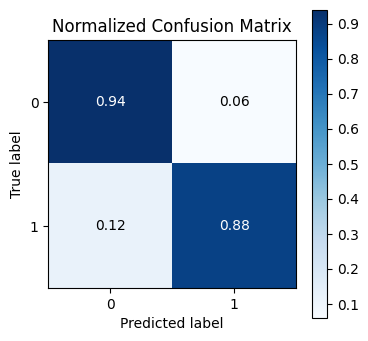

In [58]:
# Tuned KNeighborsClassifier For Validation

pipeline.set_params(Model = KNeighborsClassifier(**KNeighborsClassifierTuned.best_params))
pipeline.fit(X_train, y_train)
classifierListVal.append('KNeighborsClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1]
Balanced Accuracy 0.9444444444444444
Precision 0.8
Recall 1.0
ROC AUC score 0.9444444444444444
F1 score 0.888888888888889
MCC 0.8432740427115678
Validation score 0.9230769230769231
Confusion matrix
 [[16  2]
 [ 0  8]]


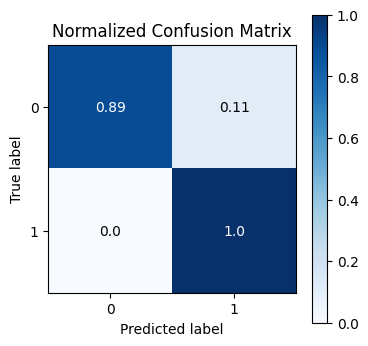

In [59]:
# GaussianProcessClassifier For Validation

pipeline.set_params(Model = GaussianProcessClassifier(random_state = seed, n_jobs=nJobs))
pipeline.fit(X_train, y_train)
classifierListVal.append('GaussianProcessClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned DecisionTreeClassifier For Validation

pipeline.set_params(Model = DecisionTreeClassifier(**DecisionTreeClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('DecisionTreeClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned GaussianNB For Validation

pipeline.set_params(Model = GaussianNB(**GaussianNBTuned.best_params))
pipeline.fit(X_train, y_train)
classifierListVal.append('GaussianNB')
y_pred = pipeline.predict(X_validation) # .predict(X)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned QuadraticDiscriminantAnalysis For Validation

pipeline.set_params(Model = QuadraticDiscriminantAnalysis(**QuadraticDiscriminantAnalysisTuned.best_params))
pipeline.fit(X_train, y_train)
classifierListVal.append('QuadraticDiscriminantAnalysis')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned LinearSVC For Validation

pipeline.set_params(Model = LinearSVC(**LinearSVCTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('LinearSVC')
y_pred = pipeline.predict(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned RidgeClassifier For Validation

pipeline.set_params(Model = RidgeClassifier(**RidgeClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('RidgeClassifier')
y_pred = pipeline.predict(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned SGDClassifier For Validation

pipeline.set_params(Model = SGDClassifier(**SGDClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('SGDClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

In [ ]:
# Tuned XGBClassifier For Validation

pipeline.set_params(Model = XGBClassifier(**XGBClassifierTuned.best_params,random_state = seed))
pipeline.fit(X_train, y_train)
classifierListVal.append('XGBClassifier')
y_pred = pipeline.predict(X_validation)
y_prob = pipeline.predict_proba(X_validation)
y_pred
print(y_pred)
y_predListVal.append(y_pred)
y_validationListVal.append(y_validation)
y_probListVal.append(y_prob)
seedListStatsVal.append(seed)
trainFracListStatsVal.append(trainFrac)

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
print("Precision", sklearn.metrics.precision_score(y_validation, y_pred))
print("Recall", sklearn.metrics.recall_score(y_validation, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_validation, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_validation, y_pred))
print("MCC", sklearn.metrics.matthews_corrcoef(y_validation, y_pred))

balancedAccuracyListVal.append(sklearn.metrics.balanced_accuracy_score(y_validation, y_pred))
precisionListVal.append(sklearn.metrics.precision_score(y_validation, y_pred))
recallListVal.append(sklearn.metrics.recall_score(y_validation, y_pred))
ROCAUCScoreListVal.append(sklearn.metrics.roc_auc_score(y_validation, y_pred))
F1ScoreListVal.append(sklearn.metrics.f1_score(y_validation, y_pred))
MCCListVal.append(matthews_corrcoef(y_validation, y_pred))

s = pipeline.score(X_validation, y_validation)
print(f"Validation score {s}")

print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_validation, y_pred))

skplt.metrics.plot_confusion_matrix(y_validation, y_pred, normalize=True,figsize=(4,4))
plt.show()

### Make final pipeline for each seed and 'test' it on the testing dataset

In [60]:
# Final pipeline

pipeline.set_params(Model = KNeighborsClassifier(**KNeighborsClassifierTuned.best_params, n_jobs=nJobs))

Pipeline(steps=[('Transforming Distribution',
                 RobustScaler(quantile_range=(25, 75))),
                ('Standard Scaler', StandardScaler()),
                ('Model',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=45,
                                      metric='euclidean', n_jobs=6,
                                      n_neighbors=2))])

In [61]:
# fit the pipeline

pipeline.fit(X, y)

Pipeline(steps=[('Transforming Distribution',
                 RobustScaler(quantile_range=(25, 75))),
                ('Standard Scaler', StandardScaler()),
                ('Model',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=45,
                                      metric='euclidean', n_jobs=6,
                                      n_neighbors=2))])

In [62]:
# load from saved
dfTestFromDisk = pd.read_excel('_dfTest_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.xlsx')
df = dfTestFromDisk

In [63]:
# select features based on dfTrain's RFE (optional)

fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed)

with open(fileName + '.json', 'r') as f:
    selected_featuresFromDisk = json.load(f)

colsToKeep = []
colsToKeep = copy.deepcopy(selected_featuresFromDisk)
colsToKeep.append(target)

df = df[colsToKeep]

In [64]:
len(colsToKeep)

240

In [65]:
# split into X and Y

X_test, y_test = X_y_split(df, target)

In [66]:
# label encode y, as above
y_test = pd.Series(le.fit_transform(y_test))

In [67]:
# impute 0s, as above

imputeWideDFMinOr0(X_test)

,ACTBL2,ACTG1,ACTG2,ACTN1,ACTN4,ADAM10,ADAMTS13,ADIPOQ,AFM,AGT,...,SVEP1,TFRC,THBS1,TLN2,TPM3,TUBA8,UGT8,VCL,VIM,VWF
0,0.238035,-1.546379,-1.517205,0.605869,0.220409,-0.132511,-0.596869,-0.865540,-0.289417,-0.372957,...,-1.475926,-0.948434,1.096785,-0.605986,0.487313,0.093620,1.019992,0.854703,-0.662153,1.552332
1,0.164659,-1.546379,-1.517205,0.146783,-0.171783,-0.298763,-0.241311,-0.445396,0.533932,0.222233,...,-0.651067,0.142736,0.337740,0.046313,0.324696,0.066913,1.019992,-0.247514,0.116570,1.714698
2,0.310621,-1.546379,-1.517205,0.622334,0.296659,-0.191976,-1.654262,-0.505006,-0.360024,-0.191644,...,-1.089110,0.121975,0.877530,-0.639579,0.141469,0.150554,1.019992,0.764212,-0.093682,1.187440
3,0.319442,-1.546379,-1.517205,0.337444,0.027481,-0.339895,-0.337704,-0.997932,0.253700,0.389514,...,-0.681654,-0.072275,0.454740,-0.242015,0.063445,-0.009888,1.019992,0.302514,0.394435,1.805422
4,-0.105398,-1.546379,-1.517205,-0.411348,-0.490759,-0.080501,-0.365737,-0.277148,0.424039,0.145391,...,-0.856880,-1.931650,0.180562,-0.231454,-0.195705,0.588111,1.019992,0.142215,0.146078,0.058512
5,-1.435105,-1.546379,-1.517205,-0.542626,-1.483101,-1.062442,-0.526324,-0.712063,0.498297,0.504817,...,-0.948027,-0.018118,-0.487850,0.141260,-0.902553,-0.477969,1.019992,-0.663922,-0.503718,0.410547
6,-0.647026,-1.546379,-1.517205,0.309178,-0.054176,-0.470395,-1.672675,-1.637876,-0.077890,-0.107259,...,-0.549213,0.105562,0.570888,0.243236,0.612258,0.290803,1.019992,-0.047862,0.533338,1.494334
7,-1.435105,-1.546379,-1.517205,-0.817767,-1.483101,-0.844119,-0.141399,-0.671580,0.132653,-0.213185,...,-0.541840,-0.020314,-0.455560,0.035101,-0.552049,0.029566,1.019992,-0.621279,-0.115550,0.352758
8,-1.435105,-1.546379,-1.517205,-0.817767,0.059684,-1.759557,-1.710125,-1.637876,0.302856,0.469412,...,-1.475926,-2.212042,-1.259770,-1.624791,-1.575466,-1.117115,1.019992,-0.240386,-0.807743,0.913663
9,-1.435105,-1.546379,-1.517205,-0.566865,-1.483101,-1.759557,-0.727181,-1.637876,-0.339604,-0.022949,...,-1.475926,-2.212042,-0.266810,-1.624791,-0.369020,-1.117115,1.019992,-0.352981,-0.807743,1.157736


In [68]:
# impute any new proteins in X_test with the min value of the dataset, as above
genesWithNANs = X_test.columns[X_test.isna().any()].tolist()

X_test[genesWithNANs] = min(X_test.min())

In [77]:
y_pred = pipeline.predict(X_test) # .predict(X)

In [78]:
y_prob = pipeline.predict_proba(X_test) # .predict(X)

In [79]:
# re-format this output
y_prob = [i[1] for i in y_prob]

# append to lists
y_predList.append(y_pred)
y_testList.append(y_test)
y_probList.append(y_prob)
seedListStats.append(seed)
trainFracListStats.append(trainFrac)

### stats

In [80]:
# sklearn scoring: https://scikit-learn.org/stable/modules/model_evaluation.html

print("Balanced Accuracy", sklearn.metrics.balanced_accuracy_score(y_test, y_pred))
print("Precision", sklearn.metrics.precision_score(y_test, y_pred))
print("Recall", sklearn.metrics.recall_score(y_test, y_pred))
print("ROC AUC score", sklearn.metrics.roc_auc_score(y_test, y_pred))
print("F1 score", sklearn.metrics.f1_score(y_test, y_pred))

# autoSKLearn scoring
#s = pipeline.score(X_train, y_train)
#print(f"Train score {s}")
s = pipeline.score(X_test, y_test)
print(f"Test score {s}")

Balanced Accuracy 0.8928571428571428
Precision 1.0
Recall 0.7857142857142857
ROC AUC score 0.8928571428571428
F1 score 0.88
Test score 0.9318181818181818


In [81]:
print("Confusion matrix\n", sklearn.metrics.confusion_matrix(y_test, y_pred))

Confusion matrix
 [[30  0]
 [ 3 11]]


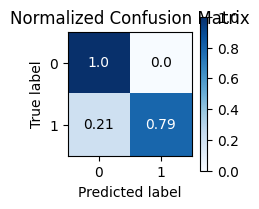

In [82]:
# plot normalized confusion matrix from the current seed
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True,figsize=(2,2))
plt.show()

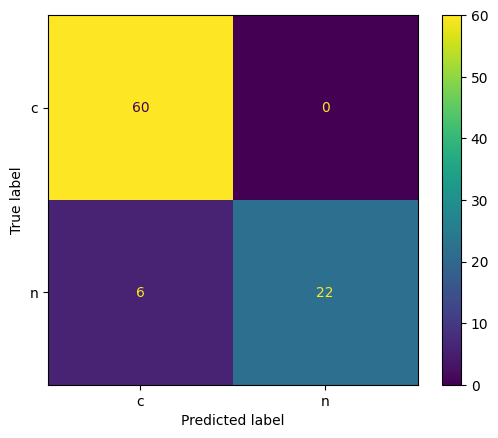

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections.abc import Iterable

def flatten(lis):
     for item in lis:
         if isinstance(item, Iterable) and not isinstance(item, str):
             for x in flatten(item):
                 yield x
         else:        
             yield item
             
cm = confusion_matrix(list(flatten(y_testList)), list(flatten(y_predList))) # for many trials

# for all models
from collections.abc import Iterable

cm = confusion_matrix(list(flatten(y_testList)), list(flatten(y_predList))) # for all models

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot()

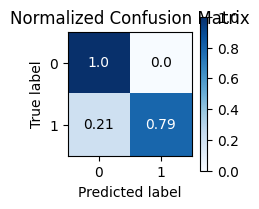

In [85]:
# plot normalized confusion matrix for all seeds/models in the current loop
skplt.metrics.plot_confusion_matrix(list(flatten(y_testList)), list(flatten(y_predList)), normalize=True,figsize=(2,2))
 
plt.show()

### Test stastistics

In [86]:
TN = cm[0][0]
FN = cm[1][0] # type II error
TP = cm[1][1]
FP = cm[0][1] # Type I error

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
precision = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# balanced accurcy
bACC = (TPR + TNR) / 2
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)
# F1 score
F1 = (2 * TP) / (2 * TP + FP + FN)
# False ommission rate
FOR = 1 - NPV
# LR+, positive liklihood ratio
LRpos = TPR / FPR
# LR-, negative liklihood ratio
LRneg = FNR / TNR
# diagnostic odds ratio
oddsRatio = LRpos/LRneg

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [87]:
print("the sensitivity/TPR is: " + str(TPR))
print("the specificity/TNR is: " + str(TNR))
print("the accuracy is: " + str(ACC))
print("the balanced accuracy is: " + str(bACC))
print("the negative predictive value (NPV) is " + str(NPV))
print("the diagnostic odds ratio is " + str(oddsRatio))
print("The positive LR is " + str(LRpos))
print("The negative LR is " + str(LRneg))
print("The F1 score is " + str(F1))

the sensitivity/TPR is: 0.7857142857142857
the specificity/TNR is: 1.0
the accuracy is: 0.9318181818181818
the balanced accuracy is: 0.8928571428571428
the negative predictive value (NPV) is 0.9090909090909091
the diagnostic odds ratio is inf
The positive LR is inf
The negative LR is 0.21428571428571427
The F1 score is 0.88


### ROC curve

In [88]:
def true_false_positive(threshold_vector, y_test):
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

def roc_from_scratch(probabilities, y_test, partitions=100):
    roc = np.array([])
    for i in range(partitions + 1):
        
        threshold_vector = np.greater_equal(probabilities, i / partitions).astype(int)
        tpr, fpr = true_false_positive(threshold_vector, y_test)
        roc = np.append(roc, [fpr, tpr])
        
    return roc.reshape(-1, 2)

In [90]:
# calc the AUROC
partitions = 100

ROC = roc_from_scratch(y_prob, y_test, partitions=partitions) # y_prob[:,1]
#ROC = roc_from_scratch(y_prob, y_test, partitions=partitions) # way that usually works
fpr, tpr = ROC[:, 0], ROC[:, 1]
rectangle_roc = 0
for k in range(partitions):
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
print('The AUROC is: ' + str(rectangle_roc))

The AUROC is: 0.9880952380952381


AUROC is 0.9880952380952381
AUROC is 0.9880952380952381


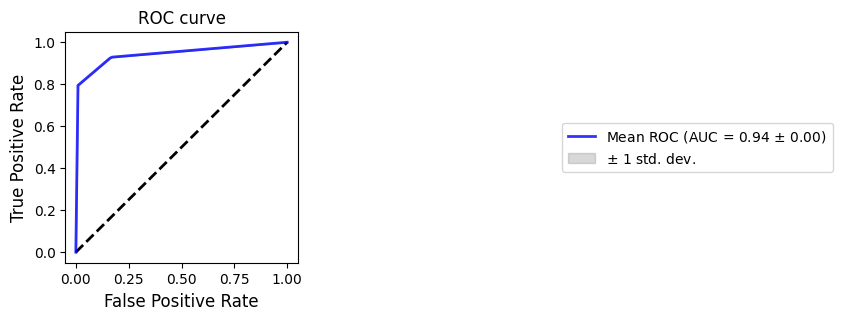

In [91]:
# overlaid ROC
from sklearn.metrics import auc

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100) # regularly spaced points

#set up plotting area
plt.figure(figsize=(3, 3))
ax = plt.axes() # enables overlay

plt.plot([0, 1], [0, 1],'--', color = 'black', lw = 2)
plt.xlim([0, 1])
plt.ylim([0, 1])

#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fprList = []
tprList = []

for y_prob, y_test in zip(y_probList,y_testList):
    
    ROC = roc_from_scratch(np.reshape(y_prob,(-1)),y_test,partitions=100) # y_prob[:,1]
    #ROC = roc_from_scratch(y_prob,y_test,partitions=100) # way that usually works

    #plt.scatter(ROC[:,0],ROC[:,1],color='black',s=20, alpha = 0.8)
    plt.plot(ROC[:,0],ROC[:,1],color='black', alpha = 0.025)
    plt.title('ROC Curve',fontsize=12)
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    #print(ROC[:,1])

    sort = np.argsort(ROC[:,0])
    interp_tpr = np.interp(mean_fpr, ROC[:,0][sort], ROC[:,1][sort]) # interp needs to be sorted
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    rectangle_roc = 0
    for k in range(partitions):
        fpr, tpr = ROC[:, 0], ROC[:, 1]
        rectangle_roc = rectangle_roc + (fpr[k]- fpr[k + 1]) * tpr[k]
    print('AUROC is ' + str(rectangle_roc))    
    aucs.append(rectangle_roc)

    #if auc < 0.5:
    #    probs = [-x for x in probs]

mean_tpr = np.mean(tprs, axis=0)
#print(mean_tpr)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="ROC curve")

plt.plot()
ax.legend(bbox_to_anchor=(3.3, .5), loc='center right', borderaxespad=0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('ROC_overlaid_' + target + '_quantType_' + quantType + '.pdf',format='pdf', dpi=500, bbox_inches='tight')# axis labels
plt.savefig('ROC_overlaid_' + target + '_quantType_' + quantType + '.svg',format='svg', dpi=500, bbox_inches='tight')# axis labels. Saves to Fugure2 folder currently

In [92]:
from itertools import chain
y_testListFlat = list(chain.from_iterable(y_testList)) 
y_predListFlat = list(chain.from_iterable(y_predList))
#y_probListFlat = list(chain.from_iterable(y_probList)) # usually works
y_probListFlat = list(chain.from_iterable(y_probList)) # y_probList[:,1]
y_1MinusProbListFlat = [1 - x for x in y_probListFlat]
y_predProbAFormattedLikeSKLearn = np.stack((y_1MinusProbListFlat, y_probListFlat), axis = 1)

### save final lists

In [93]:
import pickle

# save y_predList
fileName = '_y_predList_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(y_predList, fp)

# reload y_predList
with open(fileName, "rb") as fp:   # Unpickling
    y_predList = pickle.load(fp)



# save y_probList
fileName = '_y_probList_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(y_probList, fp)

# reload y_probList
with open(fileName, "rb") as fp:   # Unpickling
    y_probList = pickle.load(fp)



# save y_testList
fileName = '_y_testList_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(y_testList, fp)

# reload y_probList
with open(fileName, "rb") as fp:   # Unpickling
    y_testList = pickle.load(fp)


# save finalImportancesMeanList
fileName = '_finalImportancesMeanList_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(finalImportancesMeanList, fp)

# reload finalImportancesMeanList
with open(fileName, "rb") as fp:   # Unpickling
    finalImportancesMeanList = pickle.load(fp)
    

# save finalFeaturesList
fileName = '_finalFeaturesList_target-' + target + '_quantType_' + quantType + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_seed-' + str(seed) + '.pkl'

with open(fileName, "wb") as fp:   #Pickling
    pickle.dump(finalFeaturesList, fp)

# reload finalFeaturesList
with open(fileName, "rb") as fp:   # Unpickling
    finalFeaturesList = pickle.load(fp)

# Train a KNN classifier on the whole dataset that can be utilized for analysis of other plasma EV proteomics datasets

In [261]:
# load from saved
dfMLFromDisk = pd.read_excel('_dfML-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '.xlsx')

In [262]:
# Split into X and y

X, y = X_y_split(dfMLFromDisk, target)

In [263]:
imputeWideDFMinOr0(X)

,Unnamed: 0,A1BG,A2M,ACTA1,ACTB,ACTBL2,ACTG1,ACTG2,ACTN1,ACTN4,...,VIM,VTN,VWF,WDR1,YWHAB,YWHAE,YWHAG,YWHAH,YWHAQ,YWHAZ
0,0,0.830252,1.617173,1.529702,-1.517205,0.238035,-1.732577,-1.517205,0.605869,0.220409,...,-0.662153,1.651220,1.552332,0.394781,0.568536,0.793171,0.088769,0.297304,0.425608,0.877359
1,1,0.332276,1.617173,1.309366,-1.517205,0.478284,-1.732577,-1.517205,0.456010,0.041927,...,0.410026,1.576208,1.427785,-0.010363,-0.163921,0.264368,-0.276322,0.307422,0.205803,0.476802
2,2,0.357704,1.617173,1.208670,-1.517205,-0.486699,-1.732577,-1.517205,0.312867,-0.110075,...,-0.271596,1.465018,1.357034,0.002520,-0.153920,0.293756,-0.187815,0.363499,0.159687,0.525286
3,3,0.482507,1.617173,1.400820,-1.517205,0.432288,-1.732577,-1.517205,0.640151,0.196756,...,0.263245,1.466153,1.407550,0.464374,0.455905,0.528796,0.104778,0.395489,0.370452,0.871807
4,4,0.652147,1.617173,1.550001,-1.517205,0.495373,-1.732577,-1.517205,0.642554,0.355340,...,-0.089003,1.599650,1.635177,0.675694,0.686577,0.867544,-0.069715,0.407808,0.310482,0.880123
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,172,0.695520,2.162397,0.620386,0.152694,0.029239,0.256713,0.125511,-1.836067,-2.099970,...,-1.101460,1.286680,1.280491,-2.104248,-0.504451,-0.612937,-0.544749,-0.490847,-0.575711,-0.186766
173,173,0.561369,2.294855,1.989700,1.506687,1.542420,1.693424,1.588997,0.891286,0.741147,...,-1.101460,1.260654,1.245262,0.099659,0.677961,0.876450,0.702891,0.786348,0.816816,1.141525
174,174,0.592910,2.337891,1.489827,1.014633,0.979343,1.144509,1.081129,-0.105925,-0.386698,...,-1.101460,1.214992,0.924127,-0.631446,0.277585,0.419303,0.280890,0.324307,0.330923,0.792864
175,175,0.531825,2.062484,0.391271,-0.456651,-0.667611,-0.169866,-0.128379,-1.836067,-2.099970,...,-1.101460,0.803730,0.231407,-2.104248,-2.172128,-1.862757,-2.926084,-2.320411,-2.936509,-1.723978


### Transform and scale the data as in the pipeline below.

In [264]:
# transform, matching the pipeline

X_transformed = transformX(X, RobustScaler)

In [265]:
# scale to same variance, this matches the pipeline

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_transformed)
X_scaled = pd.DataFrame(X_scaled, columns=X_transformed.columns)

### Feature Selection with recursive feature extraction (RFE)
* tune minFeaturesToSelect and cv to retain ~60-150 proteins. 

In [267]:
def customRFECV (X_input):

    global selected_features
    global rfe
    global min_features_to_select
    
    estimator = RandomForestClassifier(random_state=seed)
    
    minFeaturesToSelect = 100
    
    rfe = RFECV(
        estimator=estimator, 
        
        cv=3, 
        scoring= make_scorer(quadratic_weighted_kappa),
        n_jobs = nJobs,
        step = 1,
    )
    
    rfe.fit(X_scaled, y)
    
    selected_features = []
    
    for i, feature in enumerate(X_input.columns):
        if rfe.support_[i]:
            selected_features.append(feature)

In [ ]:
customRFECV(X_scaled)

In [280]:
# save features

fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_wholeDataset'

with open(fileName + '.json', 'w') as f:
    json.dump(selected_features, f, indent=2) 

In [281]:
# to open

fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_wholeDataset'

with open(fileName + '.json', 'r') as f:
    selected_features = json.load(f)

In [282]:
# make an empty sklearn pipeline without a classifier

pipeline = Pipeline(steps=[
    ('Transforming Distribution',  RobustScaler(with_centering = True, with_scaling = True, quantile_range=(25, 75), unit_variance = False)),
    ('Standard Scaler', StandardScaler()),
    ('Model', None),
])

pipeline

Pipeline(steps=[('Transforming Distribution',
                 RobustScaler(quantile_range=(25, 75))),
                ('Standard Scaler', StandardScaler()), ('Model', None)])

In [283]:
# feature selection

df = dfMLFromDisk.copy(deep = True)

# filtered proteins based on RFE above
fileName = '_selectedFeaturesRFECV_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_wholeDataset'

with open(fileName + '.json', 'r') as f:
    selected_featuresFromDisk = json.load(f)

colsToFilter = []
colsToFilter = copy.deepcopy(selected_featuresFromDisk)
colsToFilter.append(target)
df = df[colsToFilter] # selected features from RFE

X, y = X_y_split(df, target)

le = LabelEncoder()
y = pd.Series(le.fit_transform(y))

categorical_features,continuous_features, binary_features = columns_catNumOrBin(df)

In [284]:
# impute 0s, as above

imputeWideDFMinOr0(X)

,Unnamed: 0,C1QB,C1R,CD5L,FGA,FGG,P4HB
0,0,-0.498124,-1.252469,1.417838,0.230725,2.364291,-0.362685
1,1,-0.498124,-1.252469,1.077541,0.230725,2.424627,-0.143682
2,2,-0.498124,-1.252469,1.135589,0.230725,2.304597,-0.321209
3,3,-0.498124,-1.252469,1.406347,0.230725,2.353432,-0.145631
4,4,-0.498124,-1.252469,1.093112,0.230725,2.559772,-0.190198
...,...,...,...,...,...,...,...
172,172,1.076128,0.524960,0.795438,1.829274,1.978604,-2.386640
173,173,1.398414,0.760424,1.486885,2.220795,2.376403,-2.151825
174,174,1.278032,0.827503,1.638920,1.723370,1.921522,-2.386640
175,175,1.202623,0.741566,1.476451,1.676672,1.738884,-2.386640


In [285]:
# List of classification algorithms

classifiers = [
    ('KNeighborsClassifier', KNeighborsClassifier(n_neighbors=3)),
]

In [286]:
# perform cross validation on every model in the list. Use of a network computer cluster may be required

print('\nCross-Validation:')

for j, (name, clf) in enumerate(classifiers):
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresCrossValScore = []
    r2_scores = []
    pipeline.set_params(Model = clf)
    
    print('\n')
    print(f'\n{name} Classifier:\n')
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresCrossValScore.append(crossValScore)
        
        #print('===================================================')
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        fold_std = np.std(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        fold_stdMCC = np.std(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        fold_stdAccuracy = np.std(scoresAccuracy)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
        
        print(f'\n  Mean Quadratic Weighted Kappa: {mean_score:.4f} \u00B1 {fold_std:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')


Cross-Validation:



KNeighborsClassifier Classifier:


  Mean Quadratic Weighted Kappa: 0.8755 ± 0.1508

  Matthews correlation coefficient: 0.8890 ± 0.1309

  F1 weighted score: 0.9434 ± 0.0675

  Accuracy (normalized): 0.9504 ± 0.0614

  CrossValScore: 0.7089 ± 0.1891


### use Optuna to individually tune the model

In [287]:
# setup optuna logger
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

In [ ]:
# KNeighborsClassifier

def objectiveKNeighborsClassifier(trial):
    params = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1,30),
        'weights': trial.suggest_categorical("weights", ['uniform', 'distance']),
        'metric': trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski']),
        'algorithm': trial.suggest_categorical('algorithm', ['auto', 'ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 2,200),
        'p': trial.suggest_float('p', 0.1,10),
        
    }
    
    pipeline.set_params(Model = KNeighborsClassifier(**params, n_jobs = nJobs))
    scores = []
    scoresMCC = []
    scoresF1Weighted = []
    scoresAccuracy = []
    scoresROC = []
    scoresCrossValScore = []
    
    for i, (train_index, val_index) in enumerate(cv_splits):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        
        kappa = cohen_kappa_score(y_val, y_pred, weights = 'quadratic')
        mcc = matthews_corrcoef(y_val, y_pred)
        f1Weighted = f1_score(y_val, y_pred, average = 'weighted')
        predictions = pipeline.predict_proba(X_val)[:,1] # new!
        auc = roc_auc_score(y_val, predictions)
        accuracy = balanced_accuracy_score(y_val, y_pred)
        crossValScore = cross_val_score(pipeline, X_train, y_train, cv=3)
        
        print(f'Fold {i + 1}:\n')
        
        scores.append(kappa)
        scoresMCC.append(mcc)
        scoresF1Weighted.append(f1Weighted)
        scoresAccuracy.append(accuracy)
        scoresROC.append(auc)
        scoresCrossValScore.append(crossValScore)
        fold_std = np.std(scores)
        fold_stdMCC = np.std(scoresMCC)
        fold_stdF1Weighted = np.std(scoresF1Weighted)
        fold_stdAccuracy = np.std(scoresAccuracy)
        fold_scoreROC = np.std(scoresROC)
        fold_scoreCrossValScore = np.std(scoresCrossValScore)
    
    if i == len(cv_splits) - 1:
        mean_score = np.mean(scores)
        mean_scoreMCC = np.mean(scoresMCC)
        mean_scoreF1Weighted = np.mean(scoresF1Weighted)
        mean_scoreAccuracy = np.mean(scoresAccuracy)
        mean_scoreROC = np.mean(scoresROC)
        mean_scoreCrossValScore = np.mean(scoresCrossValScore)
           
        print('* * * * * * * * * * * * * * * * * * * * * * * * * * * *\n')
        print(f'  Mean Quadratic Weighted Kappa: {mean_score:.4f}')
        print(f'\n  Matthews correlation coefficient: {mean_scoreMCC:.4f} \u00B1 {fold_stdMCC:.4f}')
        print(f'\n  F1 weighted score: {mean_scoreF1Weighted:.4f} \u00B1 {fold_stdF1Weighted:.4f}')
        print(f'\n  Accuracy (normalized): {mean_scoreAccuracy:.4f} \u00B1 {fold_stdAccuracy:.4f}')
        print(f'\n  ROC: {mean_scoreROC:.4f}')
        print(f'\n  CrossValScore: {mean_scoreCrossValScore:.4f} \u00B1 {fold_scoreCrossValScore:.4f}')
        print('\n')
        
    return mean_scoreAccuracy

studyName = 'studyKNeighborsClassifier_' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_wholeDataset'
storagestudyKNeighborsClassifier = 'sqlite:///' + studyName +'.db'
studyKNeighborsClassifier = optuna.create_study(study_name = studyName, direction='maximize', storage = storagestudyKNeighborsClassifier, load_if_exists=True)
studyKNeighborsClassifier.optimize(objectiveKNeighborsClassifier, n_trials = 500, show_progress_bar = True, catch=(FloatingPointError, RuntimeWarning))

In [299]:
best_paramsKNeighborsClassifier = studyKNeighborsClassifier.best_params
best_rmse_scoreKNeighborsClassifier = studyKNeighborsClassifier.best_value

print(f'\nKNeighborsClassifier:\n')
print('Number of finished trials:', len(studyKNeighborsClassifier.trials))
print(f'\n Best RMSE score = {best_rmse_scoreKNeighborsClassifier} \n')
print(f'\n Best Params = {best_paramsKNeighborsClassifier} \n')

# save
joblib.dump(studyKNeighborsClassifier, 'KNeighborsClassifierTuned_target-' + target + '_nSampleFilter' + str(nSamplesVal) + '_trainFrac-' + str(trainFrac) + '_wholeDataset.pkl')


KNeighborsClassifier:

Number of finished trials: 551

 Best RMSE score = 0.9718333333333333 


 Best Params = {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'algorithm': 'auto', 'leaf_size': 169, 'p': 2.976730890736924} 



['KNeighborsClassifierTuned_target-dfHarmonizedCancer_nSampleFilter60_trainFrac-0.75_wholeDataset.pkl']

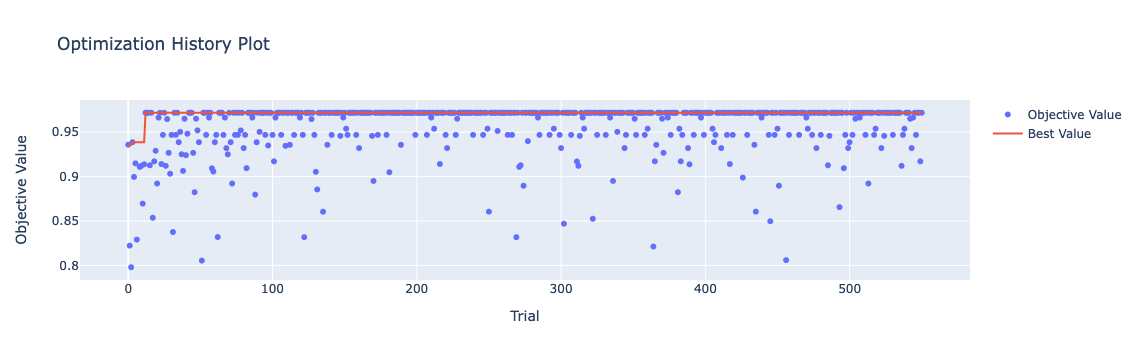

In [300]:
optuna.visualization.plot_optimization_history(studyKNeighborsClassifier)